### Import 

In [4]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math
import os
import glob
import pandas as pd
import cv2
import gc
import numpy as np
import random
import imageio
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### Extract frames from video fucntion

In [47]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

import cv2
import numpy as np

def extract_keyframes(video_path, num_keyframes, output_size):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    keyframes = []
    
    for i in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert frame to grayscale and apply canny edge detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 100, 200)
        
        # Compute threshold using Otsu's method and apply binary thresholding
        _, threshold = cv2.threshold(edges, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Compute number of edge pixels and add keyframe if threshold is exceeded
        num_edge_pixels = cv2.countNonZero(threshold)
        if num_edge_pixels > 10000:
            if len(keyframes)<num_keyframes:
                keyframes.append(format_frames(frame,output_size))
                
    if len(keyframes) == 0:
        cap = cv2.VideoCapture(video_path)
        while True:
            ret, frame = cap.read()
            if not ret:
                break
        
        # Uniform Sampling
            frame_interval=15
            if cap.get(cv2.CAP_PROP_POS_FRAMES) % frame_interval == 0:
                if len(keyframes)< num_keyframes: 
                    keyframes.append(format_frames(frame,output_size))
            
    if len(keyframes)< num_keyframes:
        b= num_keyframes-len(keyframes)
        for i in range(b):
             keyframes.append(np.zeros_like(keyframes[0]))   
            
    cap.release()
    return keyframes

def frames_from_video_file(video_path, n_frames, output_size = (120,180)):
      result = extract_keyframes(video_path, n_frames,output_size)
  
      result = np.array(result)[..., [2, 1, 0]]

      return result

### Get class names

In [6]:
class CFG:
    epochs = 10
    batch_size = 32
    classes = os.listdir("/kaggle/input/ucf21-new/UCF101_new")

### Get video paths 

In [7]:
file_paths = []
targets = []
target_name = []
for i, cls in enumerate(CFG.classes):
    sub_file_paths = glob.glob(f"/kaggle/input/ucf21-new/UCF101_new/{cls}/**.avi")
    file_paths += sub_file_paths
    targets += [i] * len(sub_file_paths)
    target_name += [cls]

In [8]:
len(file_paths)

4249

In [9]:
len(targets)

4249

In [10]:
label_dict = dict()
for i, video_label in enumerate(target_name):
    label_dict[i] = video_label

### Split the paths dataset to train and test

In [11]:
train_paths, test_paths, train_targets, test_targets = train_test_split(file_paths, targets, test_size=0.01, random_state=28)
len(train_paths), len(test_paths), len(train_targets), len(test_targets)

(4206, 43, 4206, 43)

### Split the train_paths dataset to train and val

In [12]:
train_paths, val_paths, train_targets, val_targets = train_test_split(train_paths, train_targets, test_size=0.2, random_state=23)
len(train_paths), len(val_paths), len(train_targets), len(val_targets)

(3364, 842, 3364, 842)

### Data loader

In [23]:
# using data loader to load images in batches
# `x_set` is list of path to the images
# `y_set` are the associated classes.

class train_DataLoader(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        #one hot encoding the labels data in our batch 
        frames_batch_x=[]
        for video_path in batch_x:
            frames_batch_x.append(frames_from_video_file(video_path, n_frames=10, output_size = (120,180)))
        frames_batch_x=np.array(frames_batch_x)
        cnn_features=[]
        for video in frames_batch_x:
            extracted_features = cnn_model.predict(video,verbose=0)
            cnn_features.append(extracted_features)
          
        
        return np.array(cnn_features), np.array(batch_y)


In [25]:
# using data loader to load images in batches
# `x_set` is list of path to the images
# `y_set` are the associated classes.

class val_DataLoader(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        #one hot encoding the labels data in our batch 
        frames_batch_x=[]
        for video_path in batch_x:
            frames_batch_x.append(frames_from_video_file(video_path, n_frames=10, output_size = (120,180)))
        frames_batch_x=np.array(frames_batch_x)
        cnn_features=[]
        for video in frames_batch_x:
            extracted_features = cnn_model.predict(video,verbose=0)
            cnn_features.append(extracted_features)
          
        
        return np.array(cnn_features), np.array(batch_y)


### CNN

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout,GlobalAveragePooling2D

In [27]:
# Loading VGG16 model
base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (120,180,3))

In [28]:
#creating instance of our model and adding all vgg16 layers to it
cnn_model = Sequential()
for layer in base_model.layers:
    cnn_model.add(layer)
cnn_model.add(Flatten())
#model.summary()

### Train the lstm model

In [29]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SimpleRNN, GRU

In [30]:
len(CFG.classes)

21

In [31]:
#create RNN model
lstm_model = Sequential()
#embedding for input words
#model.add(Embedding(input_dim = 10, output_dim = ,input_length = input_len))

#LSTM model
lstm_model.add(LSTM(128))
#output layer for num classes
lstm_model.add(Dense(len(CFG.classes),activation = "softmax"))

In [32]:
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "lstm_model", 
    monitor="val_accuracy",
    mode="max",
    save_best_only=True, 
    restore_best_weights=True
)
history = lstm_model.fit(
    train_DataLoader(train_paths,train_targets,batch_size=16),
    validation_data = val_DataLoader(val_paths,val_targets,batch_size=16), 
    epochs=5,callbacks=[checkpoint])
lstm_model.load_weights("lstm_model")

Epoch 1/5
211/211 [==============================] - 1864s 9s/step - loss: 1.7307 - accuracy: 0.5241 - val_loss: 1.3773 - val_accuracy: 0.6330
Epoch 2/5
211/211 [==============================] - 1856s 9s/step - loss: 0.9601 - accuracy: 0.7800 - val_loss: 0.8427 - val_accuracy: 0.8124
Epoch 3/5
211/211 [==============================] - 1874s 9s/step - loss: 0.5554 - accuracy: 0.8906 - val_loss: 0.6513 - val_accuracy: 0.8682
Epoch 4/5
211/211 [==============================] - 1917s 9s/step - loss: 0.3458 - accuracy: 0.9444 - val_loss: 0.4540 - val_accuracy: 0.9062
Epoch 5/5
211/211 [==============================] - 1966s 9s/step - loss: 0.2209 - accuracy: 0.9735 - val_loss: 0.3793 - val_accuracy: 0.9192


In [55]:
lstm_model.save('/kaggle/working/edge_detection_model.h5')

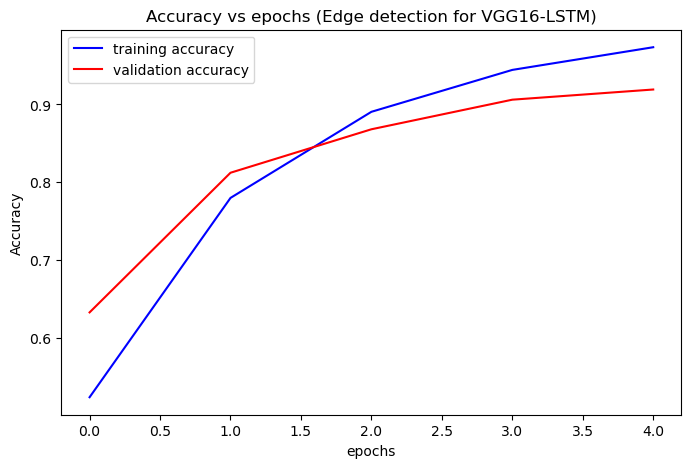

In [34]:
#accuracy plot
plt.figure(figsize = (8,5))
x = np.arange(0,5,1)
plt.plot(x,history.history["accuracy"],label = "training accuracy",c = 'blue')
plt.plot(x,history.history["val_accuracy"],label = "validation accuracy",c = 'red')
plt.legend()
plt.title("Accuracy vs epochs (Edge detection for VGG16-LSTM)")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()

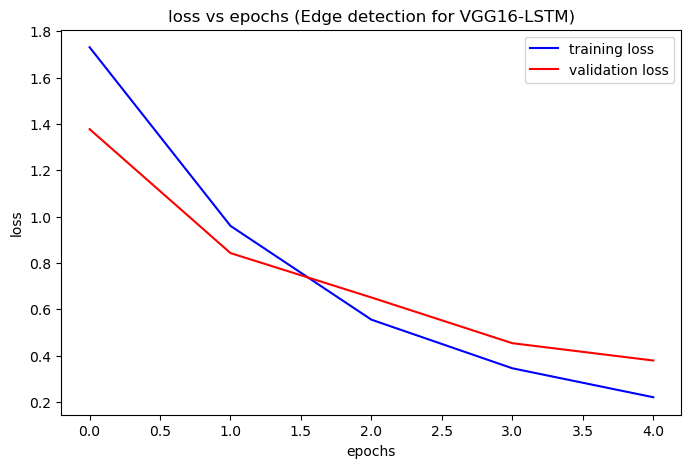

In [35]:
#accuracy plot
plt.figure(figsize = (8,5))
x = np.arange(0,5,1)
plt.plot(x,history.history["loss"],label = "training loss",c = 'blue')
plt.plot(x,history.history["val_loss"],label = "validation loss",c = 'red')
plt.legend()
plt.title("loss vs epochs (Edge detection for VGG16-LSTM)")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Prediction

In [49]:
test_videos_path = test_paths
num = np.random.randint(0,len(test_videos_path),1)
test_file_path = test_videos_path[num[0]]
test_file_path

'/kaggle/input/ucf21-new/UCF101_new/SoccerPenalty/v_SoccerPenalty_g04_c02.avi'

In [50]:
features = []
features.append(frames_from_video_file(test_file_path, n_frames = 10))
features = np.array(features)

In [51]:
cnn_features_test = []
for video in features :
    extracted_features = cnn_model.predict(video)
    cnn_features_test.append(extracted_features)

1/1 [==============================] - 0s 23ms/step


In [52]:
predicted_class = lstm_model.predict(np.array(cnn_features_test))

1/1 [==============================] - 15s 15s/step


In [53]:
# Getting indices of N = 3 maximum values
index = np.argsort(predicted_class[0])[::-1][:3]
#print("Indices:",index)

# Getting N maximum values
percentage_class = predicted_class[0][index]
#print("Values:",percentage_class)

num = -1
for i in index:
    num+=1
    a = label_dict[i]
    b = percentage_class[num]*100
    print(f"{a} : {b:.3f} percent")

SoccerPenalty : 93.664 percent
JavelinThrow : 1.855 percent
FieldHockeyPenalty : 1.426 percent
